In [75]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import pandas as pd
from sklearn.cluster import KMeans
import re


In [76]:
# lets load data
txt_file = "vrp data.txt"
data = []
with open(txt_file, "r") as file:
    lines = file.readlines()  # Read all lines in the file
    column_parsed = False
    column_names = []
    if column_parsed == False:
        # Extract column names from first line
        words = re.findall("\S+", lines[0])
        for word in words:
            column_names.append(word)
        column_parsed = True

    for line in lines[1:]:  # Loop through lines, skipping the first line
        # Extract data points from line
        dataline = re.findall("\S+", line)
        line_dict = {}
        for i, point in enumerate(dataline):
            # Convert data point to float and store in dictionary
            line_dict[column_names[i]] = float(point)
        data.append(line_dict)  # Append dictionary to list of data

# Create pandas dataframe from list of dictionaries
customers_df = pd.DataFrame(data)


In [77]:
DEPOT = customers_df[:1]

In [78]:
DEPOT

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME
0,1.0,35.0,35.0,0.0,0.0,230.0,0.0


In [79]:
customers_df = customers_df[1:]

In [80]:
#getting distance from depot for all points 
def get_distance_between_two_points(x1,y1,x2,y2):
    x_diff = x2-x1
    y_diff = y2-y1

    dist = math.sqrt(math.pow(x_diff, 2) + math.pow(y_diff, 2))
    return dist



In [81]:
customers_df["distance_FROM_DEPOT"] = customers_df.apply(lambda x: get_distance_between_two_points(x["XCOORD"],x["YCOORD"],DEPOT.loc[0,"XCOORD"], DEPOT.loc[0,"YCOORD"]), axis=1)


In [82]:
customers_df["distance_FROM_DEPOT"]

1      15.231546
2      18.000000
3      22.360680
4      25.000000
5      20.615528
         ...    
96     15.264338
97     17.204651
98     21.260292
99     17.492856
100    24.041631
Name: distance_FROM_DEPOT, Length: 100, dtype: float64

In [83]:
customers_df.head()

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME,distance_FROM_DEPOT
1,2.0,41.0,49.0,10.0,161.0,171.0,10.0,15.231546
2,3.0,35.0,17.0,7.0,50.0,60.0,10.0,18.000000
3,4.0,55.0,45.0,13.0,116.0,126.0,10.0,22.360680
4,5.0,55.0,20.0,19.0,149.0,159.0,10.0,25.000000
5,6.0,15.0,30.0,26.0,34.0,44.0,10.0,20.615528


In [84]:
def cluster_df(customers_df,n_clusters):
    #clustering data using machine learning algorithm to cluster data 

    columns_to_cluster = ["DUE_DATE",'XCOORD', 'YCOORD','distance_FROM_DEPOT']

    # Normalize the data
    data_norm = (customers_df[columns_to_cluster] -
                    customers_df[columns_to_cluster].mean()) / customers_df[columns_to_cluster].std()

    kmeans = KMeans(n_clusters=n_clusters).fit(data_norm)

    customers_df['cluster'] = kmeans.labels_
    # Sort points by distance from depot within each cluster
    customers_df = customers_df.sort_values(["cluster","READY_TIME", "distance_FROM_DEPOT"])
    return customers_df


In [85]:
customers_df = cluster_df(customers_df,30)

In [86]:
customers_df.head(5)

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME,distance_FROM_DEPOT,cluster
63,64.0,27.0,69.0,10.0,34.0,44.0,10.0,34.928498,0
11,12.0,20.0,65.0,12.0,67.0,77.0,10.0,33.541020,0
19,20.0,15.0,60.0,17.0,76.0,86.0,10.0,32.015621,0
75,76.0,49.0,11.0,18.0,69.0,79.0,10.0,27.784888,1
22,23.0,45.0,10.0,18.0,97.0,107.0,10.0,26.925824,1


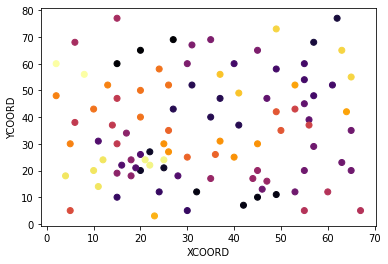

In [87]:
import matplotlib.pyplot as plt


plt.scatter(customers_df["XCOORD"],customers_df["YCOORD"],c=customers_df['cluster'],cmap="inferno")
plt.xlabel('XCOORD')
plt.ylabel('YCOORD')

plt.show()


In [88]:
class Route:
    def  __init__(self,customers_df):
        self.customers_df = customers_df
        self.route_no = self.customers_df["cluster"].to_list()[0]        
        self.n_customers = self.customers_df.shape[0]
        self.calculate_distance_matrix()

    def calculate_distance_matrix(self):
        self.dist_matrix = np.zeros((self.n_customers, self.n_customers))
        # Loop over each pair of customers
        for i in range(self.n_customers):
            for j in range(self.n_customers):
                # Calculate the Euclidean distance between the XCOORD and YCOORD values of the two customers
                x_diff = self.customers_df['XCOORD'][i] - \
                    self.customers_df['XCOORD'][j]
                y_diff = self.customers_df['YCOORD'][i] - \
                    self.customers_df['YCOORD'][j]
                dist = math.sqrt(math.pow(x_diff, 2) + math.pow(y_diff, 2))

                # Store the calculated distance in the corresponding position in the distance matrix
                self.dist_matrix[i][j] = dist

        return self.dist_matrix


    def get_total_distance(self):
              # distance between customers + distance between boundary customers and DEPOT
        distances = []
        if self.n_customers > 0:
            for i, customer in self.customers_df.iterrows():

                if i+1 >= self.n_customers:
                    continue

                next_customer = self.customers_df.iloc[i+1]
                distance_between_cust_next_customer = get_distance_between_two_points(
                    customer["XCOORD"], customer["YCOORD"], next_customer["XCOORD"], next_customer["YCOORD"])
                distances.append(distance_between_cust_next_customer)

            # distance between DEPOT and boundry customers
            b1 = self.customers_df.iloc[0]
            distance_between_b1_DEPOT = get_distance_between_two_points(
                b1["XCOORD"], b1["YCOORD"], DEPOT["XCOORD"], DEPOT["YCOORD"])
            distances.append(distance_between_b1_DEPOT)

            b2 = self.customers_df.iloc[-1]
            distance_between_b2_DEPOT = get_distance_between_two_points(
                b2["XCOORD"], b2["YCOORD"], DEPOT["XCOORD"], DEPOT["YCOORD"])
            distances.append(distance_between_b2_DEPOT)

            self.distance = 0
            for distance in distances:
                self.distance += distance

            return self.distance
        else:
            self.distance = 0
            return self.distance


    def check_capacity(self):
        self.load =0
        self.capacity_constrain = True
        for i,v in self.customers_df.iterrows():
            self.load +=v["DEMAND"]
        
        if self.load<=200:
            self.capacity_constrain = True
            return True
        else:
            self.capacity_constrain = False
            return False

    def check_time_constrain(self):
        self.time_constrain = True
        self.current_time = self.customers_df.loc[0,"READY_TIME"]
        for i,v in self.customers_df.iterrows():
            if self.current_time>v["DUE_DATE"]:
                #means that current time exceeded the upper constrain for serving the customer
                self.time_constrain = False
            elif self.current_time<=v["DUE_DATE"]:
                pass
            else:
                print("condition fails")
            
        return self.time_constrain

    def get_no_of_customers(self):
        return self.n_customers

    def sort_route(self):
        self.get_total_distance()
        self.check_capacity()
        self.check_time_constrain()
        self.customers_df = self.customers_df.sort_values(["cluster","READY_TIME", "distance_FROM_DEPOT"])
        self.customers_df.reset_index(inplace=True)

    def fitness(self):
        # calculate route fitness 
        self.check_capacity()
        self.check_time_constrain()
        self.get_total_distance()
        
        if self.capacity_constrain:
            f1 = 1000
        else:
            f1 = 0 
        
        if self.time_constrain:
            f2 = 1000
        else:
            f2 = 0

        self.fitness_value = f1*f2
        return self.fitness_value


    def mutate(self, mutation_rate):
        # randomly decide if mutation occurs based on mutation_rate
        if np.random.rand() > mutation_rate:
            return
        
        if self.get_no_of_customers()<=1:
            return 
        # randomly select two distinct customers to swap their positions
        i, j = np.random.choice(self.n_customers, size=2, replace=False)
        
        # swap the positions of the two customers
        self.customers_df.iloc[i], self.customers_df.iloc[j] = self.customers_df.iloc[j], self.customers_df.iloc[i]
        self.customers_df.reset_index(inplace=True)

        # sort the route after mutation
        # self.sort_route()
        # check if the new solution is feasible, otherwise revert back to the original solution
        if not self.check_capacity() or not self.check_time_constrain():
            self.sort_route()
        
        if not self.check_capacity() or not self.check_time_constrain():
            self.customers_df.iloc[i], self.customers_df.iloc[j] = self.customers_df.iloc[j], self.customers_df.iloc[i]
            self.customers_df.reset_index(inplace=True)
        else:
            print(f"route:{self.route_no} mutated")


In [ ]:
class Solution:
    def __init__(self,routes_list):
        self.routes = routes_list
        self.get_total_solution_distance()
        self.get_total_number_of_served_customers()
        self.get_number_of_routes()
        self.check_feasiblity()

    def get_total_solution_distance(self):
        self.solution_total_distance =0
        for route in self.routes:
            self.solution_total_distance+=route.get_total_distance()
        return self.solution_total_distance
    
    def get_total_number_of_served_customers(self):
        self.total_n_customers = 0
        for route in self.routes.copy():
            if route.get_no_of_customers()<=1:
                # self.routes.remove(route)
                pass
            else:
                self.total_n_customers+=route.get_no_of_customers()
        return self.total_n_customers
    
    def get_number_of_routes(self):
        self.no_of_routes = len(self.routes) #equalivent to no. of vehicles as well
        
    def check_feasiblity(self):
        self.feasiblity = True
        for route in self.routes:
            if route.fitness():
                pass
            else:
                self.feasiblity = False
        return self.feasiblity 

    def merge_routes(self,route1,route2):
        #merge_route? 
        #get customers df from the two routes 
        routes = self.routes.copy()
        route1_customers = route1.customers_df
        route2_customers = route2.customers_df

        #merge the two customers 
        merged_customers = pd.concat([route1_customers,route2_customers],ignore_index=True)

        #rename the cluster to be as the first route cluster
        merged_customers["cluster"] = route1_customers.loc[0,"cluster"]

        #create new route obj 
        new_route = Route(merged_customers)
        new_route.sort_route()
        if route1 in routes:
            routes.remove(route1)
        else:
            print("route1 not in self.routes")

        if route2 in routes:
            routes.remove(route2)
        else:
            print("route2 not in self.routes")
        routes.append(new_route)
        
        self.routes = routes.copy()
        self.get_total_solution_distance()
        self.get_total_number_of_served_customers()
        self.get_number_of_routes()
        self.check_feasiblity()

        return new_route
    
    def fitness_func(self):
        capacity_constrain = 1
        time_constrain = 1

        for route in self.routes:
            if not route.check_capacity():
                capacity_constrain = 0 
            if not route.check_time_constrain():
                time_constrain = 0


        fitness_value = capacity_constrain*time_constrain*(self.total_n_customers*1000-self.no_of_routes*500-self.solution_total_distance*10000)

        return round(fitness_value,2)
            
    def remove_unfeasible_routes(self):
        routes = self.routes.copy()
        for route in self.routes:
            if route.fitness()==0:
                routes.remove(route)
            
        self.routes = routes.copy()
        self.check_feasiblity()
                            
                
    def merge_two_routes_with_least_capacity(self):
        for route in self.routes:
            route.sort_route()

        routes = self.routes.copy()
        sorted_by_load = sorted(routes, key=lambda x: x.load)
        route1 = sorted_by_load[0]
        route2 = sorted_by_load[1]
        self.merge_routes(route1, route2) 

    def merge_two_routes_with_smallest_distance(self):
        for route in self.routes:
            route.sort_route()

        routes = self.routes.copy()
        sorted_by_load = sorted(routes, key=lambda x: x.distance)
        route1 = sorted_by_load[0]
        route2 = sorted_by_load[1]
        self.merge_routes(route1, route2) 


In [89]:
customers_df[customers_df["cluster"]==0].reset_index().drop(columns="index")

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME,distance_FROM_DEPOT,cluster
0,64.0,27.0,69.0,10.0,34.0,44.0,10.0,34.928498,0
1,12.0,20.0,65.0,12.0,67.0,77.0,10.0,33.541020,0
2,20.0,15.0,60.0,17.0,76.0,86.0,10.0,32.015621,0


In [90]:
DEPOT

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME
0,1.0,35.0,35.0,0.0,0.0,230.0,0.0


In [91]:
def get_routes(customers_df,n_clusters):
    routes = []
    for n in range(n_clusters):
        routes.append(Route(customers_df[customers_df["cluster"]==n].reset_index().drop(columns="index")))

    return routes

In [92]:
n_clusters=20

In [93]:
routes= get_routes(customers_df,n_clusters)

In [94]:
for route in routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},check time = {route.check_time_constrain()}")

route:0, total distance = 82.07744514047423,check capacity = True,check time = True
route:1, total distance = 70.5258011886219,check capacity = True,check time = True
route:2, total distance = 44.8481174594323,check capacity = True,check time = True
route:3, total distance = 99.8866451023706,check capacity = True,check time = True
route:4, total distance = 51.451349523455896,check capacity = True,check time = True
route:5, total distance = 80.9398429775898,check capacity = True,check time = True
route:6, total distance = 102.18562232796026,check capacity = True,check time = True
route:7, total distance = 90.39726070945355,check capacity = True,check time = True
route:8, total distance = 64.02604393145747,check capacity = True,check time = True
route:9, total distance = 149.9445319843333,check capacity = True,check time = True
route:10, total distance = 99.90181672017059,check capacity = True,check time = True
route:11, total distance = 83.02491917335094,check capacity = True,check time

In [95]:
assigned_customers = set()


In [96]:
len(routes)

20

In [97]:
sol = Solution(routes)

In [98]:
for route in sol.routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},capacity = {route.load},check time = {route.check_time_constrain()}")

route:0, total distance = 82.07744514047423,check capacity = True,capacity = 39.0,check time = True
route:1, total distance = 70.5258011886219,check capacity = True,capacity = 48.0,check time = True
route:2, total distance = 44.8481174594323,check capacity = True,capacity = 31.0,check time = True
route:3, total distance = 99.8866451023706,check capacity = True,capacity = 35.0,check time = True
route:4, total distance = 51.451349523455896,check capacity = True,capacity = 74.0,check time = True
route:5, total distance = 80.9398429775898,check capacity = True,capacity = 33.0,check time = True
route:6, total distance = 102.18562232796026,check capacity = True,capacity = 99.0,check time = True
route:7, total distance = 90.39726070945355,check capacity = True,capacity = 93.0,check time = True
route:8, total distance = 64.02604393145747,check capacity = True,capacity = 62.0,check time = True
route:9, total distance = 149.9445319843333,check capacity = True,capacity = 62.0,check time = True
ro

In [99]:
len(sol.routes)

20

In [100]:
len(sol.routes),sol.get_total_solution_distance(),sol.get_total_number_of_served_customers(),sol.check_feasiblity(),sol.fitness_func()


(20, 1585.2433015348988, 69, True, 4314756.7)

In [101]:
#use this initial solution in genetic algorithm 
initial_solution = sol

In [102]:
def generate_initial_population(customers_df,POPULATION_SIZE,n_clusters):
        # Step 1: Generate initial population
        population = []
        for i in range(POPULATION_SIZE):
            customers_df_generated = cluster_df(customers_df, n_clusters)
            routes = get_routes(customers_df_generated, n_clusters)
            sol = Solution(routes)
            len(sol.routes),sol.get_total_solution_distance(),sol.get_total_number_of_served_customers(),sol.check_feasiblity(),sol.fitness_func()
            population.append(sol)
        return population


In [103]:
import random

def rank_based_selection(population, k=2):
    fitness_list = [sol.fitness_func() for sol in population]
    ranked_list = sorted(range(len(fitness_list)), key=lambda k: fitness_list[k])
    ranks = [len(fitness_list) - i for i in ranked_list]
    probs = [rank / sum(ranks) for rank in ranks]
    selected_indices = random.choices(range(len(population)), weights=probs, k=k)
    return [population[i] for i in selected_indices]


In [104]:
def create_offspring(parent1, parent2, crossover_rate):
    # check if crossover should occur
    if random.random() > crossover_rate:
        # if not, return a clone of parent1 or parent2 at random
        if random.random() < 0.5:
            return parent1
        else:
            return parent2

    p1_routes = parent1.routes
    p2_routes = parent2.routes

    # Choose a random crossover point
    crossover_point = random.randint(1, len(p1_routes) - 1)

    # Create the offspring by combining the parents' genetic material
    offspring_routes = p1_routes[:crossover_point] + p2_routes[crossover_point:]
    offspring = Solution(offspring_routes)

    return offspring


In [ ]:
offspring.routes

In [ ]:
offspring.fitness_func()

7120106.87

In [ ]:
offspring.fitness_func()

7120106.87

In [105]:
n_generation = 300
n_population = 100 
co_rate = 0.8
m_rate = 0.3
n_clusters = 20
pop = generate_initial_population(customers_df, n_population,n_clusters)

# for g in range(n_generation):
#     print(g)
#     pop = generate_initial_population(customers_df, n_population,n_clusters)
#     print("Population created")
#     parent1,parent2 = rank_based_selection(pop,2)
#     print("Two parents created")
#     offspring = create_offspring(parent1,parent2,co_rate)
#     print("an offspring created")
#     # Mutate offspring
#     for route in offspring.routes:
#         route.mutate(m_rate)
#     print(f"Route mutated")

    
#     # Calculate fitness for offspring
#     offspring_fitness = offspring.fitness_func()
#     print(f"offspring fitness:{offspring_fitness}")

#     # Replace worst solution in population with offspring
#     pop_fitness = [sol.fitness_func() for sol in pop]

#     worst_idx = pop_fitness.index(min(pop_fitness))
#     print(f"worest solution fitness:{pop_fitness[worst_idx]}")
    
#     if offspring_fitness > pop_fitness[worst_idx]:
#         pop[worst_idx] = offspring

#     best_idx = pop_fitness.index(max(pop_fitness))
#     best_sol = pop[best_idx]

#     print("best solution till now:")
#     print(len(best_sol.routes),best_sol.get_total_solution_distance(),best_sol.get_total_number_of_served_customers(),best_sol.check_feasiblity(),best_sol.fitness_func())




In [106]:
pop

In [107]:
for sol in pop:
    print(len(sol.routes),sol.get_total_solution_distance(),sol.get_total_number_of_served_customers(),sol.check_feasiblity(),sol.fitness_func())


20 2035.2361389112534 100 True 6964763.86
20 2162.988437415374 98 True 6637011.56
20 2072.760826615956 99 True 6827239.17
20 2055.689529456892 100 True 6944310.47
20 2195.707559763374 99 True 6704292.44
20 2040.381376771933 100 True 6959618.62
20 2117.765165325609 99 True 6782234.83
20 2050.3041130205243 99 True 6849695.89
20 2034.331600116014 100 True 6965668.4
20 2130.941943633675 98 True 6669058.06
20 2124.365157495037 99 False 0.0
20 2119.81094446792 99 True 6780189.06
20 2116.1798668015763 99 True 6783820.13
20 2080.265974919451 100 True 6919734.03
20 2144.6577722946067 99 True 6755342.23
20 2119.3300236546575 100 True 6880669.98
20 2058.127200523538 100 True 6941872.8
20 2064.304648290591 100 True 6935695.35
20 2140.7653676968152 99 True 6759234.63
20 2182.2491380400506 99 True 6717750.86
20 2060.393456016305 100 True 6939606.54
20 2170.969804806631 100 True 6829030.2
20 2092.05155668597 99 True 6807948.44
20 2095.3985745346977 99 True 6804601.43
20 2093.3021875179707 100 True 69